

# İrem TANRIVERDİ


#### <span style="background-color:#7299EB">After applying required preprocessing steps, fit specified models to the data.</span>    
    
#### <span style="background-color:#7299EB">    When necessary you can use (%70 train - %30 test) or (%60 train - %20 validation - %20 test) splits for the questions. </span>


## PART 1-Classification
    
**Q1.(50).** Fit Logistic Regression, Gaussian Naive Bayes,  Decision Tree models to your training set. **Perform hyperparameter tuning** and try to figure out the best model. Report the model performances. Which performance metric would you prefer to use for Part I? Why? Comment on your findings.
    

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix ,matthews_corrcoef
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from dtreeviz.trees import dtreeviz 
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

In [39]:
data= pd.read_csv("data.csv")
data

,x0,x1,y
0,281.931378,145.018979,1
1,357.750303,119.483971,1
2,381.598615,146.832723,1
3,377.749439,134.867567,1
4,329.865988,143.835645,0
...,...,...,...
2995,155.827887,57.999559,4
2996,176.507074,77.625664,4
2997,181.920623,64.164662,5
2998,161.356403,49.129629,4


### Description of the data

- There are 3 variables and 3000 observations in the dataset. All the variables are numeric. 

- To fit machine learning models to your data set should be complete. As seen from the outputs below, there is no missing observation in the data.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      3000 non-null   float64
 1   x1      3000 non-null   float64
 2   y       3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [41]:
for columns in data:
    print(columns, "--> # of missing value", data[columns].isna().sum())

x0 --> # of missing value 0
x1 --> # of missing value 0
y --> # of missing value 0


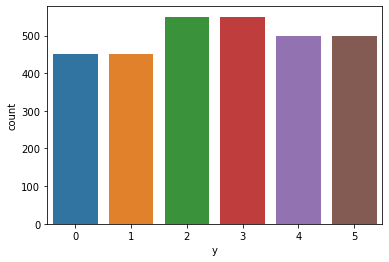

In [42]:
ax = sns.countplot(x="y", data=data)

In [242]:
data['y'].value_counts(normalize=True)

2    0.183333
3    0.183333
4    0.166667
5    0.166667
0    0.150000
1    0.150000
Name: y, dtype: float64

We obtain the proportion and frequency plot of target variable (y), in above output. Proportion for each level of y seems closer.

## 1.1. Logistic Regression

### Data Normalization

**Before doing normalization, model evaluation metrics is around 0.5**. We normalized the independent variables to increase the model efficiency. Because to maximize the model’s efficiency, it’s always a good idea to normalize the data to a common scale.

In [43]:
# Normalization:
x = data.drop(["y"], axis = 1)
y = data.y.values

x = (x - np.min(x)) / (np.max(x) - np.min(x))
x.head()

,x0,x1
0,0.661401,0.859755
1,0.903934,0.701071
2,0.980221,0.871026
3,0.967908,0.796670
4,0.814736,0.852401


Since target variable (y) has more than 2 level, multinomial logistic regression was applied. Firstly, the dataset which will be used to build the model is divided randomly into 2 parts namely training set and validation set(or testing set). The model is trained on the training dataset and it's model evaluation metrics are calculated by predicting the target variable for those data points which is not present during the training that is test set. 70% of the data was taken as training set and 30% of the data was taken as test set.

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=571)

# define the multinomial logistic regression model
mlr = LogisticRegression(multi_class='multinomial', solver='saga', random_state=571, 
                         penalty='l1', C=1.1, max_iter =800)
mlr.fit(x_train, y_train)
y_pred = mlr.predict(x_test)

In [45]:
print('intercept:', mlr.intercept_)
print('slope:', mlr.coef_)

intercept: [-21.20576996  -6.52501286   0.91292841  15.4686806    5.79477452
   5.55439929]
slope: [[  3.81887363  36.20483945]
 [ 11.59201673  11.09103145]
 [ 24.21873927 -24.73408594]
 [-46.91839239   0.        ]
 [ -0.66045707   0.        ]
 [  0.           0.        ]]


### Model evaluation metrics

When the response is binary or more than 2 categories in a machine learning model, we use the classification models like logistic regression, decision trees, random forest, XGboost, convolutional neural network etc. Then, to evaluate these models, we use classification metrics. Accuarcy, precision, recall, F1-score, Log loss, and Receiver Operating Characteristics (ROC) Curve are mostly known classification metrics.

- Accuracy is true positive rate.

$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $ <br>

- Precision is defined as positive predicted values.

$ Precision = \frac{TP}{TP + FP} $ <br>

- Recall (Sensitivity) is the proportion of actual positive cases which are correctly identified.

$ Recall = \frac{TP}{TP + FN} $ <br>

- F1 score is a combination of two important error metrics: Precision and Recall. Thus, it can be considered as the Harmonic mean of Precision and Recall error metrics.

$ F1-score= 2*\frac{precision * recall}{precision + recall} $ <br>

In [46]:
# obtain model evaluation metrics
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=7, random_state=571)

n_scores_accuracy = cross_val_score(mlr, x_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy for logistic regression: %.4f (%.4f)' % (mean(n_scores_accuracy), std(n_scores_accuracy)))

n_scores_recall = cross_val_score(mlr, x_test, y_test, scoring='recall_weighted', cv=cv, n_jobs=-1)
print('Mean recall for logistic regression: %.4f (%.4f)' % (mean(n_scores_recall), std(n_scores_recall)))

n_scores_precision = cross_val_score(mlr, x_test, y_test, scoring='precision_weighted', cv=cv, n_jobs=-1)
print('Mean precision for logistic regression: %.4f (%.4f)' % (mean(n_scores_precision), std(n_scores_precision)))

n_scores_f1 = cross_val_score(mlr, x_test, y_test, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1-score for logistic regression: %.4f (%.4f)' % (mean(n_scores_f1), std(n_scores_f1)))

Mean Accuracy for logistic regression: 0.8287 (0.0371)
Mean recall for logistic regression: 0.8287 (0.0371)
Mean precision for logistic regression: 0.8533 (0.0792)
Mean F1-score for logistic regression: 0.7971 (0.0469)


To obtain model evaluation metrics and to incease model efficiency cross validation was applied with 20 splits and 7 repeats. Namelly, we fitted 140 folds. After fitting 140 folds, mean model evalutaion metrics are obtained from 140 fits. In above output, we can see the mean accuracy, recall, precision and F1-score.


- Correct classification rate is 0.83. It can be considered high.

- Ratio of correctly predicted positive observations to the total predicted positive observations (Precision) is 0.85 which can be considered high. 

- Recall is 0.83 which is the ability of a test to correctly classify an individual as “1”. It means that model doing a mistake of 17% when predicting the individual who really classified as 1.

- F1 score has a lower value than others.

**All the model evaluation metrcis have accepted level of metrics. However, better model fit performance can be achieved with other machine learning algorithms.**

## 1.2. Gaussian Naive Bayes

Naive Bayes are a group of supervised machine learning classification algorithms based on the Bayes theorem.

In [47]:
# Test Train Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 571)

# Naive Bayes model
nb = GaussianNB()
nb.fit(x_train, y_train)

# Prediction
y_pred_nb = nb.predict(x_test)

### Hyperparameter Tuning


In [48]:
cv_method = RepeatedStratifiedKFold(n_splits=10,  n_repeats=3, random_state=571)

gs_NB = GridSearchCV(estimator=GaussianNB(),  param_grid={'var_smoothing': np.logspace(0,-9, num=200)}, 
                     cv=cv_method, verbose=2, n_jobs=-1)

gs_NB.fit(x_train, y_train)
print(gs_NB.best_estimator_)

Fitting 30 folds for each of 200 candidates, totalling 6000 fits
GaussianNB(var_smoothing=0.0026430814869741054)


In [49]:
# Model evaluation metrics

predict_test= gs_NB.predict(x_test)

accuracy = round(accuracy_score(y_test, predict_test), 4)
print("Accuracy for gaussian naive bayes is", accuracy)

recall = round(recall_score(y_test, predict_test, average="weighted"), 4)
print("Recall for gaussian naive bayes is", recall)

precision = round(precision_score(y_test, predict_test, average="weighted"), 4)
print("Precision for gaussian naive bayes is", precision)

f1 = round(f1_score(y_test, predict_test, average="weighted"), 4)
print("F1-score for gaussian naive bayes is", f1)

Accuracy for gaussian naive bayes is 0.9656
Recall for gaussian naive bayes is 0.9656
Precision for gaussian naive bayes is 0.9664
F1-score for gaussian naive bayes is 0.9656


Gaussian Naive Bayes model was conducted by splitting data into two parts again. 30% of the data was taken as test set and 70% of the data was taken as training set. For hyperparameter tunning and increasing model efficiency cross validation was applied with 10 splits and 3 repeats. Namelly, we fitted 30 folds for each of 200 candidates, namelly totalling 6000 fits. Gaussian Naive Bayes has a parameter which name is **"var_smoothing"**. It is the portion of the largest variance of all features that is added to variances for calculation stability. While we were doing cross validation, we also choose the best var_smooting in the range (0, -9) with 200 samples. As a result of the model with cross validation, best estimator for var_smoothing parameter is observed as 0.00264. That means, final model is conducted with this estimator. After model fitting, model evaluation metrics for gaussian naive bayes model was obtained.

After fitting 30 folds for each of 200 candidates, mean model evalutaion metrics are obtained from 6000 fits. In above output, we can see the mean accuracy, recall, precision and F1-score.

**The closer the model evaluation metrics are to 1, the better the model fit.**

- Correct classification rate is 0.97 which is very high. 

- Ratio of correctly predicted positive observations to the total predicted positive observations (Precision) is 0.97 which is considerably high again. 

- Recall is 0.97 which is the ability of a test to correctly classify an individual as “1”. It means that model doing a mistake of **only 3%** when predicting the individual who really classified as 1. (error is very small)

- F1 score is also 0.97.

**All the model evaluation metrcis have value very close to 1. That means model fit of Gaussian Naive Bayes is very good. When we compare the model evaluation metrics for Logistic Regression and Gaussian Naive Bayes, there are big diffence between them. Gaussian Naive Bayes overestimate the Logistic Regression (Gaussian Naive Bayes has higher value of accuracy, recall, precision and F1-score).**

## 1.3. Decision Tree


- max_depth int, default=None

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

- min_samples_split int or float, default=2

The minimum number of samples required to split an internal node: If int, then consider min_samples_split as the minimum number.

- ccp_alpha non-negative float, default=0.0

Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. 

- min_weight_fraction_leaf float, default=0.0

The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

In [54]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(criterion = "gini",
            random_state = 571, max_depth=30, min_samples_leaf=10,
                           ccp_alpha=0, min_weight_fraction_leaf=0)

# Train Decision Tree Classifer
dt = dt.fit(x_train,y_train)

#Predict the response for test dataset
y_pred_dt = dt.predict(x_test)

In [55]:
# obtain model evaluation metrics
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=2, random_state=571)



n_scores_accuracy = cross_val_score(dt, x_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy for decision tree is: %.4f (%.4f)' % (mean(n_scores_accuracy), std(n_scores_accuracy)))

n_scores_recall = cross_val_score(dt, x_test, y_test, scoring='recall_weighted', cv=cv, n_jobs=-1)
print('Mean recall for decision tree is: %.4f (%.4f)' % (mean(n_scores_recall), std(n_scores_recall)))

n_scores_precision = cross_val_score(dt, x_test, y_test, scoring='precision_weighted', cv=cv, n_jobs=-1)
print('Mean precision for decision tree is: %.4f (%.4f)' % (mean(n_scores_precision), std(n_scores_precision)))

n_scores_f1 = cross_val_score(dt, x_test, y_test, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean F1-score for decision tree is: %.4f (%.4f)' % (mean(n_scores_f1), std(n_scores_f1)))

Mean Accuracy for decision tree is: 0.9856 (0.0214)
Mean recall for decision tree is: 0.9856 (0.0214)
Mean precision for decision tree is: 0.9878 (0.0177)
Mean F1-score for decision tree is: 0.9855 (0.0212)


Decision Tree model was conducted by splitting data into two parts again. 30% of the data was taken as test set and 70% of the data was taken as training set. For hyperparameter tunning and increasing model efficiency cross validation was applied with 20 splits and 2 repeats. Namelly, we fitted 40 folds, namelly totalling 40 fits. Decision tree has a parameters which name are **"max_depth", "min_samples_split", "ccp_alpha" and "min_weight_fraction_leaf"**. Explanation of the parameters are shown above. "max_dept" is taken as 30, "min_sample_leafs" is taken as 10, "ccp_alpha" and "min_weight_fraction_leaf" are taken as 0 because when they increases evalution metrics are decreased. As a result of the model with cross validation, model evaluation metrics for decision tree model was obtained.

After fitting 40 folds, mean model evalutaion metrics are obtained from 40 fits. In above output, we can see the mean accuracy, recall, precision and F1-score.

**The closer the model evaluation metrics are to 1, the better the model fit.**

- Correct classification rate is 0.99 which is very high. 

- Ratio of correctly predicted positive observations to the total predicted positive observations (Precision) is 0.99 which is considerably high again. 

- Recall is 0.99 which is the ability of a test to correctly classify an individual as “1”. It means that model doing a mistake of **only 1%** when predicting the individual who really classified as 1. (error is very small)

- F1 score is also 0.99.

**All the model evaluation metrcis have value very very close to 1. That means model fit of Decision Tree is very good. When we compare the model evaluation metrics for logistic regression, Decision tree and  Gaussian Naive Bayes, there are big diffence between Decision Tree and Logistic Regression. Metrics for Gaussian Naive Bayes and Decision Tree are close to each other, but Decision Tree model overestimate the logistic regression and Gussian Naive Bayes (Decision Tree model has higher value of accuracy, recall, precision and F1-score compared with decision tree and gaussian naive bayes).**

### <span style="background-color:violet">Then, let visualize decision tree with 2 different ways.</span>    

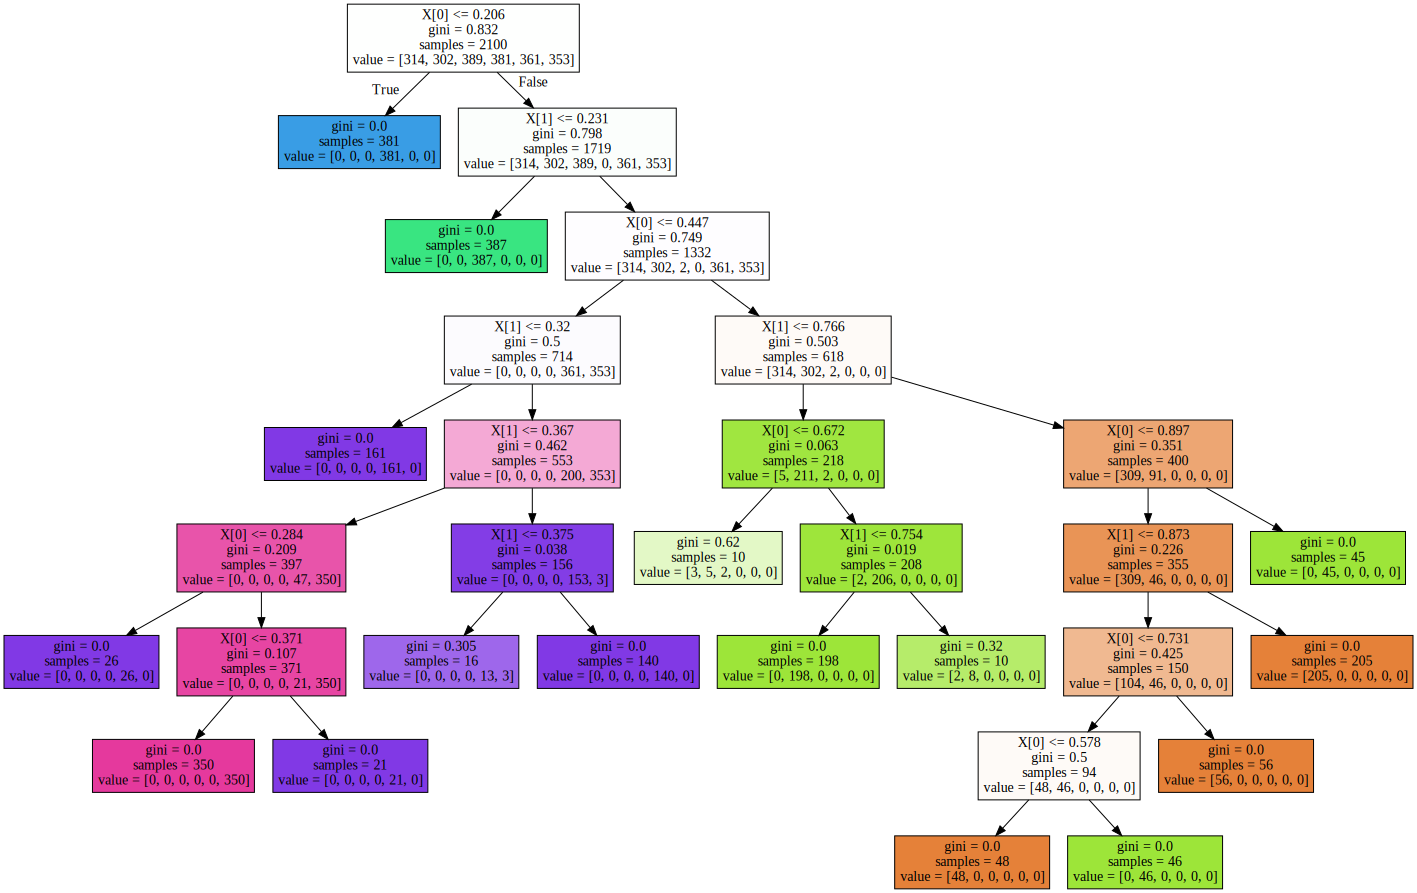

In [36]:
dot_data = tree.export_graphviz(dt, out_file=None, filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

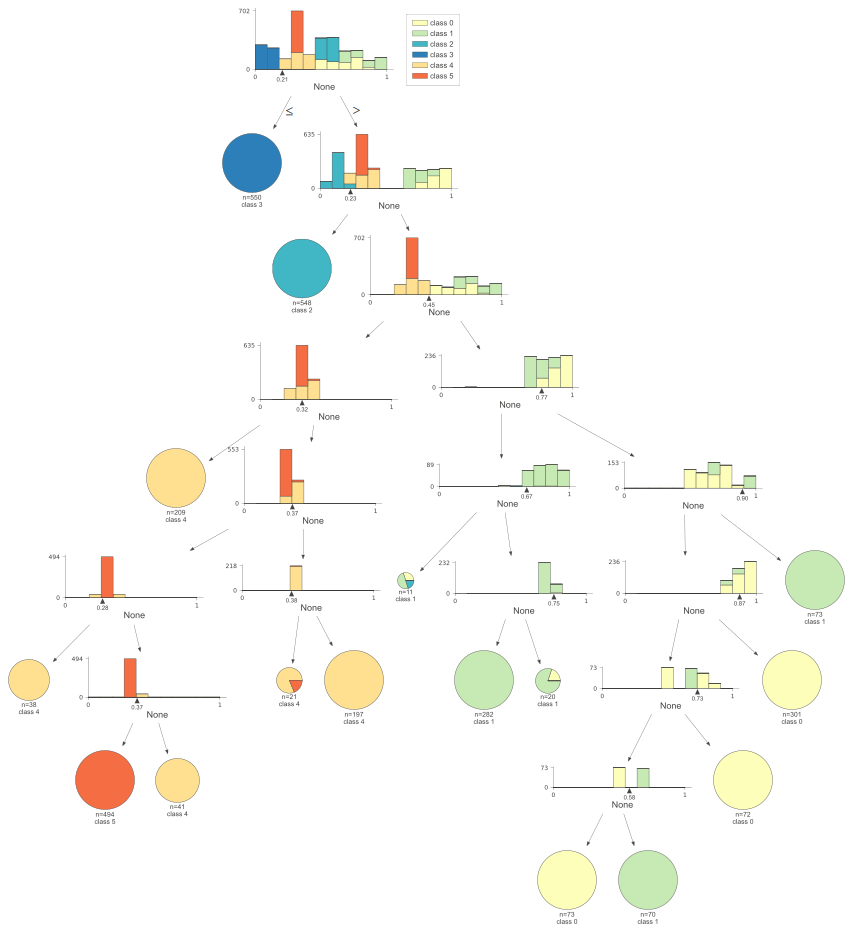

In [37]:
fig = dtreeviz(dt, x, y)
fig

 <span style="background-color:yellow">Please note that for all algorithms, (%70 train - %30 test) split was used. The reason of it, we achived the highest model evaluation metrics with this split.</span>    

### PART 2
    
**Q2.(15).** Generate k-means models for k= 2, 3, 4, 5, 6, 7, 8, 9, and 10. Determine the optimal value of k by looking at the wss graph and silhouette scores.   


The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset. The first step is to randomly select k centroids, where k is equal to the number of clusters you choose. Centroids are data points representing the center of a cluster.

Data sets usually contain numerical features that have been measured in different units. The values for all features must be transformed to the same scale. Now the data are ready to be clustered. 

In [56]:
data_cl = data.drop('y', 1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_cl)
scaled_features

array([[ 0.86075756,  1.56677603],
       [ 1.83659342,  0.98439746],
       [ 2.14353576,  1.6081422 ],
       ...,
       [-0.42644192, -0.2772736 ],
       [-0.69111598, -0.62017857],
       [-0.66321758, -0.64222315]])

- init controls the initialization technique. 

- n_clusters sets k for the clustering step. This is the most important parameter for k-means.

- n_init sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

- max_iter sets the number of maximum iterations for each initialization of the k-means algorithm.

### Choosing the Appropriate Number of Clusters

The elbow method and silhouette coefficient are often used as complementary evaluation techniques rather than one being preferred over the other. 

To perform the  <span style="background-color:yellow">Elbow method </span>  , run several k-means, increment k with each iteration, and record the SSE.

The <span style="background-color:yellow">Silhouette Coefficient</span> is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster. Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

Let conduct a k-means models for each k between the values 2 and 10. Then, obtain silhouette score for each k. Then, choose optimal value of k which has the highest average silhouette score.

In [57]:
for k in range(2, 11, 1):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    # Compute the silhouette scores for each algorithm
    kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_).round(2)
    print("kmeans silhouette score is", kmeans_silhouette, "when k is", k)

kmeans silhouette score is 0.67 when k is 2
kmeans silhouette score is 0.64 when k is 3
kmeans silhouette score is 0.71 when k is 4
kmeans silhouette score is 0.67 when k is 5
kmeans silhouette score is 0.58 when k is 6
kmeans silhouette score is 0.5 when k is 7
kmeans silhouette score is 0.42 when k is 8
kmeans silhouette score is 0.57 when k is 9
kmeans silhouette score is 0.49 when k is 10


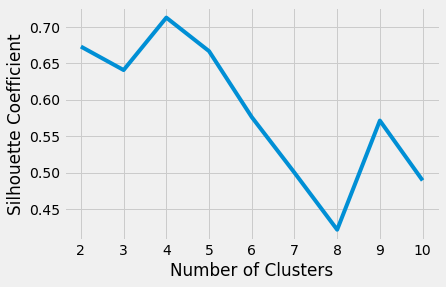

In [58]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

As seen from the plot, when k=4, we reach the highes average silhouette score. 

Then, let look at WSS plot for optimal k.

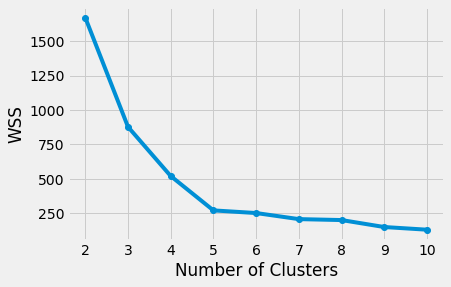

In [59]:
cluster_wss = []
for k in range(2, 11):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    cluster_wss.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), cluster_wss, marker = 'o')
plt.xticks(range(2, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.show()

Now we can see that there is not so much decrease in WSS even after we increase the number of clusters beyond 5. 4 is also seem good. Thus, **by WSS plot and silhouette score, optimal k is choosen as 4.**


**Q3.(15).** Generate DBSCAN models for epsilon values between 0.1 (included) and 2.5(included) incrementing it with steps=0.10 and for min_samples=5, 10, 15 and 20. Find the optimal value of k by adjusted rand scores. (While calculating adjusted rand scores, you will need true labels. Please see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)   



DBScan is a density-based clustering algorithm. The key fact of this algorithm is that the neighbourhood of each point in a cluster which is within a given radius (R) must have a minimum number of points (M). This algorithm has proved extremely efficient in detecting outliers and handling noise.


<span style="background-color:orange"> Our data contains y variable which has 6 labels which are ["0", "1", "2", "3", "4", "5"]. We will use these labels in the evaluation methods (Adjusted rand score). They are our **"true label values"**.</span>

In [60]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(data.y)
true_labels

array([1, 1, 1, ..., 5, 4, 4])

<span style="background-color:orange"> Then, we generate DBSCAN models for each value of epsilon between the range (0.1, 2.5) and each value of minimum sample (5, 10, 15, 20). After generating DBSCAN for each possible value of epsilon and min_sample, we calculate **Adjusted rand score** to choose optimal value of k and epsilon.</span>

In [61]:
for i in range(5, 25, 5):
    for j in np.arange(0.1, 2.6, 0.10):
        dbscan = DBSCAN(eps=j,  min_samples=i)
        dbscan.fit(scaled_features)
        ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_).round(4)
        print("Adjusted rand score is", ari_dbscan, "when min sample is", i, "and epsilon is", round(j,1))

Adjusted rand score is 0.9965 when min sample is 5 and epsilon is 0.1
Adjusted rand score is 0.824 when min sample is 5 and epsilon is 0.2
Adjusted rand score is 0.7091 when min sample is 5 and epsilon is 0.3
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 0.4
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 0.5
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 0.6
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 0.7
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 0.8
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 0.9
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 1.0
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 1.1
Adjusted rand score is 0.2545 when min sample is 5 and epsilon is 1.2
Adjusted rand score is 0.0 when min sample is 5 and epsilon is 1.3
Adjusted rand score is 0.0 when min sample is 5 and epsilon is 1.4
Adjusted rand score is 0.0 

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The adjusted Rand values  range between -1 and 1. A score close to 0.0 indicates random assignments, and a score close to 1 indicates perfectly labeled clusters.

<span style="background-color:violet">When we look at the ARI values, we see that the closest value to 1 is 0.9965. Maximun ARI value obtained when epsilon value is 0.1 and minimum sample is 5. Thus, optimal k value is selelcted as 5.</span>

**Q4.(20).** Plot the clusters for only the optimal k values based on predicted clusters that you obtain Q2 and Q3. Plot the original data based on the true labels. Did you obtain the same optimal k values in Q2 and Q3? Comment on the quality of the clusters that you obtained in Q2 and Q3. Can we predict the true label of the data by using clustering? Which algorithm gave a better result? What could be the reason one of them outperforms in different cases?

------------------------------------------------------------------------------------------------------------

  <span style="background-color:orange">In Q2 kmeans clustering was applied and optimal k was choosen as 4. Besides, in Q3 DBSCAN model was applied and optimal k was choosen as 5 and optimal epsilon choosen as 0.1. **We obtain different optimal k values for different methods.**
Let fit the models again with their optimal values respectively. After that, we will visualize the clusters with the true labels which is shown in Q3 (we used them to calculate ARI). Then, let visualize clusters for each method. </span>

In [64]:
# k means
kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300,random_state=42)
label_kmeans = kmeans.fit_predict(scaled_features)
label_kmeans

array([3, 3, 3, ..., 0, 0, 0], dtype=int32)

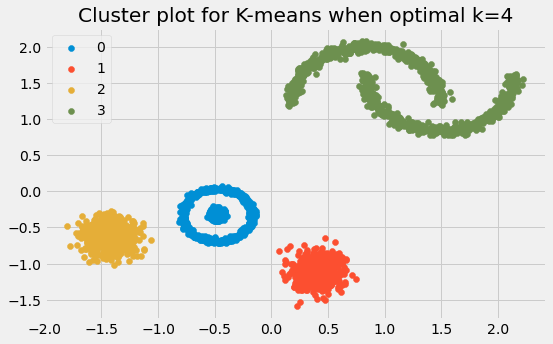

In [67]:
#Getting unique labels
u_labels_kmeans = np.unique(label_kmeans)
 
#plotting k-means:
plt.figure(figsize=(8,5)) 
for i in u_labels_kmeans:
    plt.scatter(scaled_features[label_kmeans == i , 0] , scaled_features[label_kmeans == i , 1] , label = i)
plt.legend()
plt.title("Cluster plot for K-means when optimal k=4")
plt.show()

In [68]:
# DBSCAN
dbscan = DBSCAN(eps=0.1,  min_samples=5)
label_dbscan = dbscan.fit_predict(scaled_features)
label_dbscan

array([0, 0, 0, ..., 5, 4, 4])

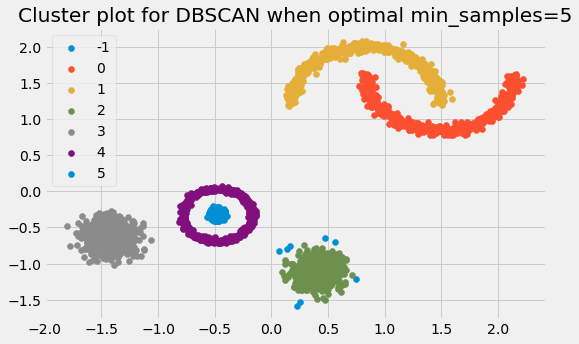

In [69]:
u_labels_dbscan = np.unique(label_dbscan)
 
#plotting DBSCAN:
plt.figure(figsize=(8,5)) 
for i in u_labels_dbscan:
    plt.scatter(scaled_features[label_dbscan == i , 0] , scaled_features[label_dbscan == i , 1] , label = i)
plt.legend()
plt.title("Cluster plot for DBSCAN when optimal min_samples=5")
plt.show()

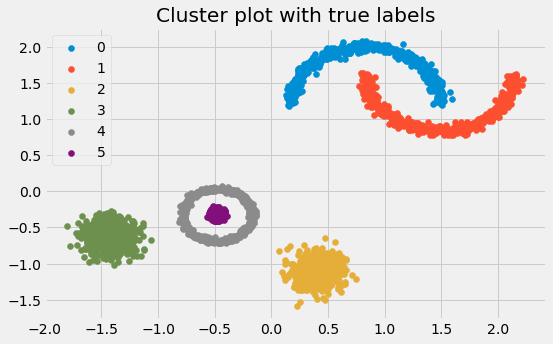

In [70]:
u_labels_true = np.unique(true_labels)
 
#plotting true labels:
plt.figure(figsize=(8,5)) 
for i in u_labels_true:
    plt.scatter(scaled_features[true_labels == i , 0] , scaled_features[true_labels == i , 1] , label = i)
plt.legend()
plt.title("Cluster plot with true labels")
plt.show()

Between these 3 cluster plots in above there is slight differences. The number of clusters in the plots is different, respectively 4=Kmeans, 7=DBSCAN, 6=True labels. When we look at the predicted labels in the K-means model, we see that there are 4 labels which are  ["0", "1", "2", "3"]. When we look at the DBSCAN model, we see that there are 7 predicted labels, which are ["-1", "0", "1", "2", "3", "4", "5"]. Our true label values are [ "0", "1", "2", "3", "4", "5"]  (original data values for y). The K-means model underestimated 2 labels based on true label values. The DBSCAN model, on the other hand, overestimate 1 more label based on true label values. If we consider that underestimating is not good, we can say that the DBSCAN model is better in terms of including all true label values. Let's obtain the numerical methods to understand which model is better. Let's look at the adjusted rand scores and silhouette coefficients of these two models.

In [71]:
kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_).round(4)
dbscan_silhouette = silhouette_score(scaled_features, dbscan.labels_).round(4)


ari_dbscan = adjusted_rand_score(true_labels, dbscan.labels_).round(4)
ari_kmeans = adjusted_rand_score(true_labels, kmeans.labels_).round(4)

print("Adjusted rand score for kmeans is", ari_kmeans, "and silhouette coefficient for kmeans is",kmeans_silhouette)
print("Adjusted rand score for dbscan is", ari_dbscan, "and silhouette coefficient for dbscan is",dbscan_silhouette)

Adjusted rand score for kmeans is 0.7091 and silhouette coefficient for kmeans is 0.7129
Adjusted rand score for dbscan is 0.9965 and silhouette coefficient for dbscan is 0.4357


The silhouette coefficient is higher for the k-means algorithm. The DBSCAN algorithm appears to find more natural clusters according to the shape of the data. Based on the above output, we can see that the silhouette coefficient was misleading. ARI shows that DBSCAN is the best choice for the synthetic crescents example as compared to k-means. (Adjusted rand score for dbscan is very close to 1, that indicates perfectly labeled clusters). Hence, we can predict the true label of the data by using dbscan clustering. As stated in Q3 DBSCAN algorithm is extremely efficient in detecting outliers and handling noise. If our dataset have many outlier, that may be reason of DBSCAN outperform the kmeans.

In [ ]:
# Model evaluation metrics and confusion matrix

accuracy2 = round(accuracy_score(y_test, y_pred_nb), 4)
precision2 = round(precision_score(y_test, y_pred_nb), 4)
recall2 = round(recall_score(y_test, y_pred_nb), 4)
F1_score2 = round(f1_score(y_test, y_pred_nb, average='macro'), 4)

#roc-score
y_score2 = nb.predict_proba(x_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
roc_score2 = round(roc_auc_score(y_test, y_score2), 4)

print('ROC AUC Score=', roc_score2)
print("Accuracy=", accuracy2)
print("Recall=",  recall2)
print("Precision=",  precision2)
print("F1-score=",  F1_score2)

labels=np.unique(y)
plot_confusion_matrix(nb, x_test, y_test, display_labels=labels, values_format='.0f', cmap=plt.cm.Purples)
plt.show()

plt.subplots(1, figsize=(6,6))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()